In [ ]:
%env CUDA_VISIBLE_DEVICES=1

In [1]:
import os
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import pairwise_distances

from collections import defaultdict
import os
import random
import numpy as np
from tqdm import tqdm
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_DIR=r'D:\Users\amira\Documents\datasets\emotions\podcast with text'

In [3]:
compare_filenames=lambda x: int(os.path.splitext(x)[0])

In [4]:
video_path=os.path.normpath(os.path.join(DATA_DIR,'video.mp4'))
print(video_path)
faces_path=os.path.normpath(os.path.join(DATA_DIR,'faces'))

D:\Users\amira\Documents\datasets\emotions\podcast with text\video.mp4


In [5]:
# set to 1 to take every frame
FRAMES_TO_SKIP = 10

# Face detection + OCR

In [5]:
import tensorflow as tf

print(tf.__version__)
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

from facial_analysis import FacialImageProcessing
imgProcessing=FacialImageProcessing(False)

2.5.3


In [6]:
import numpy as np
import cv2
import math
from skimage import transform as trans
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : array
        order: {'x1', 'y1', 'x2', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : array
        order: {'x1', 'y1', 'x2', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

#print(get_iou([10,10,20,20],[15,15,25,25]))

def preprocess(img, bbox=None, landmark=None, **kwargs):
    M = None
    image_size = [224,224]
    src = np.array([
      [30.2946, 51.6963],
      [65.5318, 51.5014],
      [48.0252, 71.7366],
      [33.5493, 92.3655],
      [62.7299, 92.2041] ], dtype=np.float32 )
    if image_size[1]==224:
        src[:,0] += 8.0
    src*=2
    if landmark is not None:
        dst = landmark.astype(np.float32)

        tform = trans.SimilarityTransform()
        #dst=dst[:3]
        #src=src[:3]
        #print(dst.shape,src.shape,dst,src)
        tform.estimate(dst, src)
        M = tform.params[0:2,:]
        #M = cv2.estimateRigidTransform( dst.reshape(1,5,2), src.reshape(1,5,2), False)
        #print(M)

    if M is None:
        if bbox is None: #use center crop
            det = np.zeros(4, dtype=np.int32)
            det[0] = int(img.shape[1]*0.0625)
            det[1] = int(img.shape[0]*0.0625)
            det[2] = img.shape[1] - det[0]
            det[3] = img.shape[0] - det[1]
        else:
              det = bbox
        margin = 0#kwargs.get('margin', 44)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin//2, 0)
        bb[1] = np.maximum(det[1]-margin//2, 0)
        bb[2] = np.minimum(det[2]+margin//2, img.shape[1])
        bb[3] = np.minimum(det[3]+margin//2, img.shape[0])
        ret = img[bb[1]:bb[3],bb[0]:bb[2],:]
        if len(image_size)>0:
              ret = cv2.resize(ret, (image_size[1], image_size[0]))
        return ret 
    else: #do align using landmark
        assert len(image_size)==2
        warped = cv2.warpAffine(img,M,(image_size[1],image_size[0]), borderValue = 0.0)
        return warped

In [7]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

if not os.path.exists(faces_path):
    os.mkdir(faces_path)

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('total_frames:',total_frames)
#cap.set(cv2.CAP_PROP_POS_FRAMES,0)

frame_count = 0
counter=0
bboxes,all_text=[],[]

for frame_count in tqdm(range(0, total_frames-1, FRAMES_TO_SKIP)):
    ret, frame_bgr = cap.read()
    counter+=FRAMES_TO_SKIP
    cap.set(cv2.CAP_PROP_POS_FRAMES, counter)
    if not ret:
        #cap.release()
        #break
        continue
    frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    bounding_boxes, points = imgProcessing.detect_faces(frame)
    points = points.T
    if len(bounding_boxes)!=0:
        sorted_indices=bounding_boxes[:,0].argsort()
        bounding_boxes=bounding_boxes[sorted_indices]
        points=points[sorted_indices]

        faces_folder=os.path.join(faces_path, str(counter)) 
        if not os.path.exists(faces_folder):
            os.mkdir(faces_folder)
        for i,b in enumerate(bounding_boxes):
            outfile=os.path.join(faces_folder, str(i)+'.png')
            if not os.path.exists(outfile):
                if True:
                    p=None
                else:
                    p=points[i]
                    p = p.reshape((2,5)).T
                face_img=preprocess(frame_bgr,b,p)

                if np.prod(face_img.shape)==0:
                    print('Empty face ',b,' found for ',filename)
                    continue
                cv2.imwrite(outfile, face_img) 
        bboxes.append(bounding_boxes)
        
        frame = cv2.resize(frame, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_LINEAR)
        results=pytesseract.image_to_data(frame,lang='rus+eng',output_type=pytesseract.Output.DICT)
        frame_text=[]
        for i in range(0, len(results["text"])):
            x = results["left"][i]
            y = results["top"][i]
            w = results["width"][i]
            h = results["height"][i]
            text = results["text"][i].strip()
            conf = float(results["conf"][i])
            if conf > 0 and len(text)>1:
                frame_text.append((text,int(x/frame.shape[1]*frame_bgr.shape[1]),int(y/frame.shape[0]*frame_bgr.shape[0]),
                                 int(w/frame.shape[1]*frame_bgr.shape[1]),int(h/frame.shape[0]*frame_bgr.shape[1])))
        all_text.append(frame_text)
    
cap.release()    

total_frames: 6149


100%|██████████| 615/615 [21:49<00:00,  2.13s/it]


## Text processing 

In [8]:
def combine_words(photo_text):
    #print(photo_text)
    if len(photo_text)>0:
        new_text=[photo_text[0]]
        for word_ind in range(1,len(photo_text)):
            prev_text,x1,y1,w1,h1=new_text[-1]
            center1_x,center1_y=x1+w1,y1+h1/2
            cur_text,x2,y2,w2,h2=photo_text[word_ind]
            center2_x,center2_y=x2,y2+h2/2
            dist=abs(center1_x-center2_x)+abs(center1_y-center2_y)
            #print(prev_text,cur_text,dist)
            if dist>=7: #0.01:
                new_text.append(photo_text[word_ind])
            else:
                new_text[-1]=(prev_text+' '+cur_text,x1,y1,x2+w2-x1,y2+h2-y1)
    else:
        new_text=[]
    return new_text

In [9]:
def get_closest_texts(bboxes,photo_text):
    best_texts,best_distances=[],[]
    for (x1,y1,x2,y2,_) in bboxes:
        face_x,face_y=x1,y2
        #print(x1,y1,x2,y2)
        best_dist=10000
        best_text=''
        for (text,x,y,w,h) in photo_text:
            if y>y1:
                dist_y=abs(face_y-y)
                if face_x<x:
                    dist_x=x-face_x
                elif face_x>x+w:
                    dist_x=face_x-x-w
                else:
                    dist_x=0
                #print(text,dist_x, dist_y,x,y,w,h)
                if dist_x<best_dist and dist_y<1.5*(y2-y1):
                    best_dist=dist_x
                    best_text=text
        #print(best_text,best_dist,(x2-x1))
        if best_dist>=(x2-x1)*2:
            best_text=''
        if best_text!='':
            for i,prev_txt in enumerate(best_texts):
                if prev_txt==best_text:
                    if best_distances[i]<best_dist:
                        best_text=''
                        break
                    else:
                        best_texts[i]=''
        best_texts.append(best_text)
        best_distances.append(best_dist)
    return best_texts

# FaceId 

In [6]:
import torch
from PIL import Image
from torchvision import datasets, transforms

print(f"Torch: {torch.__version__}")
device = 'cuda:0'

Torch: 1.11.0+cu115


In [7]:
torch.cuda.is_available()

True

In [8]:
import timm
model=timm.create_model('tf_efficientnet_b0_ns', pretrained=False)
model.classifier=torch.nn.Identity()
model.load_state_dict(torch.load(r'models\state_vggface2_enet0_new.pt'))

model=model.to(device)
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [9]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [10]:
embeddings=[]
i=0
for filename in tqdm(sorted(os.listdir(faces_path), key=compare_filenames)):
    faces_dir=os.path.join(faces_path,filename)
    imgs=[]
    for img_name in sorted(os.listdir(faces_dir), key=compare_filenames):
        img = Image.open(os.path.join(faces_dir,img_name))
        img_tensor = test_transforms(img)
        imgs.append(img_tensor)

    if len(imgs)>0:        
        scores = model(torch.stack(imgs, dim=0).to(device))
        scores=scores.data.cpu().numpy()
    else:
        scores=[]

    embeddings.append(scores)
    '''
    if len(scores)!=len(bboxes[i]):
        print('Error',filename,i,len(scores),len(bboxes[i]))
    '''
    i+=1

print(len(embeddings))

100%|██████████| 611/611 [01:28<00:00,  6.89it/s]

611


## Faces only 

In [11]:
face_files=[]
subjects=None
X_recent_features=None
for i,filename in enumerate(sorted(os.listdir(faces_path), key=compare_filenames)):
    f=preprocessing.normalize(embeddings[i],norm='l2')
    if X_recent_features is None:
        for face_ind in range(len(f)):
            face_files.append([(i,filename,face_ind)])
        X_recent_features=f
    else:
        dist_matrix=pairwise_distances(f,X_recent_features)
        sorted_indices=dist_matrix.argsort(axis=1)
        for face_ind,sorted_inds in enumerate(sorted_indices):
            closest_ind=sorted_inds[0]
            min_dist=dist_matrix[face_ind][closest_ind]
            if min_dist<0.85 or (len(sorted_inds)>1 and min_dist<dist_matrix[face_ind][sorted_inds[1]]-0.1):
                X_recent_features[closest_ind]=f[face_ind]
                face_files[closest_ind].append((i,filename,face_ind))
            else:
                face_files.append([(i,filename,face_ind)])
                X_recent_features=np.concatenate((X_recent_features,[f[face_ind]]),axis=0)
print(len(face_files), [len(files) for files in face_files])

9 [618, 529, 419, 577, 581, 5, 1, 176, 19]


## Faces+bboxes

In [16]:
def get_square(bb):
    return abs((bb[2]-bb[0])*(bb[3]-bb[1]))
SQUARE_THRESHOLD=900

In [116]:
face_files=[]
subjects=None
X_recent_features=None
recent_bboxes=[]
for i,filename in enumerate(sorted(os.listdir(faces_path), key=compare_filenames)):
    f=preprocessing.normalize(embeddings[i],norm='l2')
    if X_recent_features is None:
        large_face_indices=[]
        for face_ind in range(len(f)):
            if get_square(bboxes[i][face_ind])>SQUARE_THRESHOLD:
                large_face_indices.append(face_ind)
                recent_bboxes.append(bboxes[i][face_ind])
                face_files.append([(i,filename,face_ind)])
        if len(large_face_indices)>0:
            X_recent_features=f[np.array(large_face_indices)]
        #print(X_recent_features.shape)
        #recent_bboxes=list(deepcopy(bboxes[i]))
    else:
        matched_faces=[]
        for face_ind,face_bbox in enumerate(bboxes[i]):
            closest_ind=-1
            best_iou=0
            for ind, bbox in enumerate(recent_bboxes):
                iou=get_iou(face_bbox,bbox)
                if iou>best_iou:
                    best_iou=iou
                    closest_ind=ind
            if best_iou>0.15:
                d=np.linalg.norm(f[face_ind]-X_recent_features[closest_ind])
                if d<1.0:
                    X_recent_features[closest_ind]=f[face_ind]
                    face_files[closest_ind].append((i,filename,face_ind))
                    recent_bboxes[closest_ind]=bboxes[i][face_ind]
                    matched_faces.append(face_ind)
        if len(matched_faces)<len(bboxes[i]):
            dist_matrix=pairwise_distances(f,X_recent_features)
            sorted_indices=dist_matrix.argsort(axis=1)
            for face_ind,sorted_inds in enumerate(sorted_indices):
                if face_ind in matched_faces or get_square(bboxes[i][face_ind])<=SQUARE_THRESHOLD:
                    continue
                closest_ind=sorted_inds[0]
                min_dist=dist_matrix[face_ind][closest_ind]
                if min_dist<0.85:# or (len(sorted_inds)>1 and min_dist<dist_matrix[face_ind][sorted_inds[1]]-0.1):
                    X_recent_features[closest_ind]=f[face_ind]
                    face_files[closest_ind].append((i,filename,face_ind))
                    recent_bboxes[closest_ind]=bboxes[i][face_ind]
                else:
                    face_files.append([(i,filename,face_ind)])
                    X_recent_features=np.concatenate((X_recent_features,[f[face_ind]]),axis=0)
                    recent_bboxes.append(bboxes[i][face_ind])
                    #print(filename,i,X_recent_features.shape,face_ind,closest_ind,dist_matrix[face_ind][closest_ind])
                    #print(dist_matrix)
print(len(face_files), [len(files) for files in face_files])

11 [612, 554, 478, 577, 581, 1, 2, 1, 1, 117, 1]


## Text + faces

In [18]:
import editdistance
def levenstein(txt1,txt2):
    if txt1=='' or txt2=='':
        return 1
    #return editdistance.eval(txt1,txt2)
    return (editdistance.eval(txt1,txt2))/(max(len(txt1),len(txt2)))

def get_name(name2count):
    #print(name2count)
    return max(name2count, key=name2count.get)

In [113]:
face_files=[]
recent_texts=[]
X_recent_features=[]

for i,filename in enumerate(sorted(os.listdir(faces_path), key=compare_filenames)):
    photo_text=combine_words(all_text[i])
    best_texts=get_closest_texts(bboxes[i],photo_text)
    f=preprocessing.normalize(embeddings[i],norm='l2')

    if len(recent_texts)==0:
        for face_ind,txt in enumerate(best_texts):
            if len(txt)>=4:
                recent_texts.append({txt:1})
                face_files.append([(i,filename,face_ind)])
                X_recent_features.append(f[face_ind])
    else:
        for face_ind,txt in enumerate(best_texts):
            if len(txt)>=4:
                closest_ind=-1
                best_d_txt=1
                for ind,recent_text_set in enumerate(recent_texts):
                    d_txt=min([levenstein(txt,recent_text) for recent_text in recent_text_set])
                    if d_txt<best_d_txt:
                        best_d_txt=d_txt
                        closest_ind=ind

                face_dist=np.linalg.norm(X_recent_features[closest_ind]-f[face_ind])
                if (best_d_txt<=0.45 and face_dist<=1.0) or face_dist<=0.8:
                    if txt in recent_texts[closest_ind]:
                        recent_texts[closest_ind][txt]+=1
                    else:
                        recent_texts[closest_ind][txt]=1
                    face_files[closest_ind].append((i,filename,face_ind))
                    X_recent_features[closest_ind]=f[face_ind]
                elif best_d_txt>0.45:
                    recent_texts.append({txt:1})
                    face_files.append([(i,filename,face_ind)])
                    X_recent_features.append(f[face_ind])
                    #print(videoname,filename,i,face_ind,face_dist,txt,best_d_txt,recent_texts[closest_ind])

subjects=[get_name(name2count) for name2count in recent_texts]

---------------

0 612 (0, '50', 0)
1 554 (0, '50', 1)
2 478 (0, '50', 2)
3 577 (0, '50', 3)
4 581 (3, '80', 1)
9 117 (428, '4330', 3)


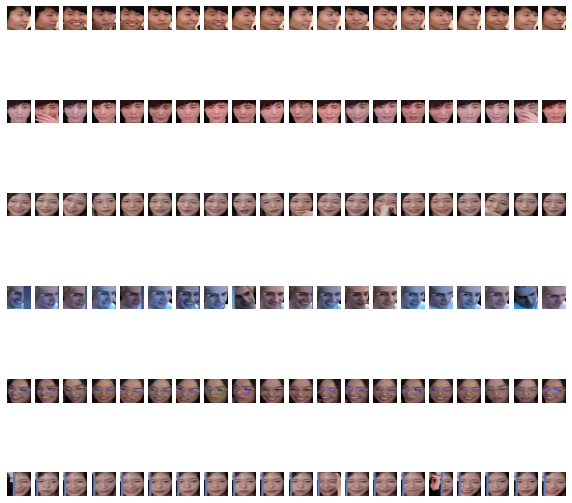

In [117]:
import random
plt_ind=1
minNoPhotos=20
min_num_files=100
no_clusters=len([i for i,files in enumerate(face_files) if len(files)>min_num_files])
plt.figure(figsize=(10,10))
for i,files in enumerate(face_files):
    if len(files)>min_num_files:
        print(i,len(files),files[0])
        
        for j in range(minNoPhotos):
            f=random.choice(files)
            fpath=os.path.join(faces_path,f[1],str(f[2])+'.png')
            plt.subplot(no_clusters,minNoPhotos,plt_ind)
            if j==0 and subjects is not None:
                plt.title(subjects[i])
            plt.imshow(Image.open(fpath))
            plt.axis('off')
            plt_ind+=1
plt.show()

# Emotions

In [12]:
if False:
    model_name='enet_b2_8'
    IMG_SIZE=260 #224 #
else:
    model_name='enet_b0_8'
    IMG_SIZE=224
PATH=r'models/'+model_name+'.pt'
test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
feature_extractor_model = torch.load(PATH)

In [13]:
classifier_weights=feature_extractor_model.classifier[0].weight.cpu().data.numpy()
classifier_bias=feature_extractor_model.classifier[0].bias.cpu().data.numpy()
print(classifier_weights.shape,classifier_weights)
print(classifier_bias.shape,classifier_bias)

(8, 1280) [[ 0.00515123 -0.00972202 -0.01203173 ...  0.05333852 -0.06858566
  -0.12183831]
 [ 0.05973773 -0.01306326 -0.00981904 ...  0.04521868  0.03189689
   0.16130415]
 [-0.02749952 -0.1972647   0.02720864 ...  0.18251328 -0.03125019
  -0.07623435]
 ...
 [-0.15567695  0.09653756 -0.02194299 ... -0.07001057  0.00730149
   0.11114535]
 [ 0.08313771 -0.16218805 -0.10610525 ... -0.05499801 -0.00550514
   0.12355816]
 [-0.04981646  0.23458022 -0.16780637 ... -0.24049994  0.02247157
  -0.10648516]]
(8,) [-0.02634053  0.05532073 -0.09343545  0.01225835  0.05623824  0.05436933
 -0.0242617   0.02030101]


In [14]:
feature_extractor_model.classifier=torch.nn.Identity()
feature_extractor_model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [15]:
def get_probab(features):
    x=np.dot(features,np.transpose(classifier_weights))+classifier_bias
    #print(x)
    e_x = np.exp(x - np.max(x,axis=0))
    return e_x / e_x.sum(axis=1)[:,None]

In [16]:
if len(classifier_bias)==7:
    idx_to_class={0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}
    INTERESTING_STATES=[0,1,2,3,6]
else:
    idx_to_class={0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}
    INTERESTING_STATES=[0,2,3,4,7]
    color_scheme = {'Anger':'red', 'Contempt':'black', 'Disgust':'purple', 'Fear':'cyan', 'Happiness':'yellow', 'Neutral':'gray', 'Sadness':'blue', 'Surprise':'green'}
print(idx_to_class)

{0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}


In [17]:
X_global_features,X_scores=[],[]
filenames = []
for filename in tqdm(sorted(os.listdir(faces_path), key=compare_filenames)):
    filenames.append(filename)
    faces_dir=os.path.join(faces_path,filename)
    imgs=[]
    for img_name in sorted(os.listdir(faces_dir), key=compare_filenames):
        img = Image.open(os.path.join(faces_dir,img_name))
        img_tensor = test_transforms(img)
        if img.size:
            imgs.append(img_tensor)

    if len(imgs)>0:
        features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
        features=features.data.cpu().numpy()
        scores=get_probab(features)
        #print(videoname,filename,features.shape,scores.shape)
        X_global_features.append(features)
        X_scores.append(scores)

100%|██████████| 611/611 [00:43<00:00, 14.02it/s]


# Create gifs 

In [125]:
from IPython import display
from PIL import Image, ImageFont, ImageDraw 
min_num_files=100
unicode_font = ImageFont.truetype(r"ClearSans-Light.ttf", 8)
gif=[]
no_clusters=len([i for i,files in enumerate(face_files) if len(files)>min_num_files])
for subject_ind,files in enumerate(face_files):
    if len(files)>min_num_files:
        #print(len(files),files[0])
        prev_filename_ind=-1
        start_i=0
        current_scores,current_features=[],[]
        prev_emotion=-1
        emotion2longest_sequence={}
        for i,(file_ind,filename,face_ind) in enumerate(files):
            filename_ind=int(filename)
            if prev_filename_ind==-1:
                prev_filename_ind=filename_ind-FRAMES_TO_SKIP 
            new_emotion=np.argmax(X_scores[file_ind][face_ind])
            #print('check',prev_filename_ind,filename_ind-1, new_emotion,current_emotion)

            # if one of the conditions is not met, then fill in emo2long_seq 
            if prev_filename_ind!=filename_ind-FRAMES_TO_SKIP or new_emotion!=prev_emotion or new_emotion not in INTERESTING_STATES: 
                if len(current_scores)>=10:
                    emotion=np.argmax(np.mean(current_scores,axis=0))
                    if emotion in emotion2longest_sequence:
                        if emotion2longest_sequence[emotion][0]<len(current_scores):
                            emotion2longest_sequence[emotion]=(len(current_scores),start_i,i-1)
                    else:
                        emotion2longest_sequence[emotion]=(len(current_scores),start_i,i-1)
                    #print(start_i,i-1,idx_to_class[emotion])
                start_i=i
                current_scores,current_features=[],[]
            prev_filename_ind=filename_ind
            prev_emotion=new_emotion
            current_scores.append(X_scores[file_ind][face_ind])
            current_features.append(X_global_features[file_ind][face_ind]) # not used

        if len(emotion2longest_sequence)>0:
            for emotion, (_,start_i, end_i) in emotion2longest_sequence.items():
                #print(idx_to_class[emotion],start_i,end_i,len(files))
                for i in range(start_i,min(start_i+20,end_i)+1):
                    #print(files[i])
                    fpath=os.path.join(faces_path,files[i][1],str(files[i][2])+'.png')
                    img=Image.open(fpath)
                    img = img.resize((112,112), Image.ANTIALIAS)
                    draw = ImageDraw.Draw(img) 
                    #draw.text((0, 0), subjects[subject_ind], align ="left", font=unicode_font,fill=(0,0,255,255))
                    draw.text((0, 10), idx_to_class[emotion], align ="left",font=unicode_font, fill=(0,255,0,255))
                    gif.append(img.convert("P",palette=Image.ADAPTIVE))
                    #print(gif)

if False:
    for img in gif:
        display.clear_output(wait=True)
        plt.axis('off')
        plt.imshow(img)
        plt.show()
if True and len(gif)>0:
    print("Saved gif!")
    gif[0].save('emo.gif', save_all=True,optimize=False, append_images=gif[1:],disposal=2)

D:\Users\amira\AppData\Local\Temp\ipykernel_2480\3717585357.py:46: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((112,112), Image.ANTIALIAS)
D:\Users\amira\AppData\Local\Temp\ipykernel_2480\3717585357.py:50: DeprecationWarning: ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.
  gif.append(img.convert("P",palette=Image.ADAPTIVE))


Saved gif!


# Visualization

In [18]:
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import Dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

D:\Users\amira\AppData\Local\Temp\ipykernel_8260\2108174690.py:4: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
D:\Users\amira\AppData\Local\Temp\ipykernel_8260\2108174690.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [19]:
min_num_files=100
all_emotions = []
frame_idxs = []
emotions_dfs = []
subject_idxs = []
for subject_ind,files in enumerate(face_files):
    if len(files)>min_num_files:
        subject_idxs.append(str(subject_ind))
        all_emotions.append([])
        frame_idxs.append([])
        for i,(file_ind,filename,face_ind) in enumerate(files):
            new_emotion=np.argmax(X_scores[file_ind][face_ind])
            frame_idxs[-1].append(int(filename))
            all_emotions[-1].append(new_emotion)
        emotions_dfs.append(pd.Series(all_emotions[-1]).value_counts().rename(idx_to_class))
emo_df = pd.DataFrame(emotions_dfs).fillna(0)
emo_df.insert(0,'Name',subject_idxs)

In [30]:
emo_df

,Name,Happiness,Contempt,Fear,Disgust,Surprise,Neutral,Anger,Sadness
0,0,190.0,119.0,102.0,68.0,42.0,40.0,40.0,17.0
1,1,20.0,130.0,106.0,48.0,39.0,29.0,113.0,44.0
2,2,234.0,10.0,52.0,16.0,1.0,29.0,31.0,46.0
3,3,55.0,170.0,5.0,86.0,5.0,13.0,241.0,2.0
4,4,268.0,19.0,14.0,49.0,3.0,24.0,202.0,2.0
5,7,91.0,18.0,23.0,6.0,0.0,11.0,8.0,19.0


In [25]:
fig = px.pie(values=emo_df.loc[emo_df['Name']=='0'].values[0][1:],names=emo_df.columns[1:], title="Emotions of first person", color=emo_df.columns[1:],color_discrete_map=color_scheme)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [22]:
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H2('Overall emotions'),
    dcc.Graph(id='graph'),
    html.P("Choose name of the person:"),
    dcc.Dropdown(id='person_name',
        options=emo_df['Name'].values,
        value=emo_df['Name'].values[0], clearable=False)
])
# Define callback to update graph
@app.callback(
    Output("graph", "figure"), 
    Input("person_name", "value")
)
def generate_chart(person_name):
    fig = px.pie(values=emo_df.loc[emo_df['Name']==person_name].values[0][1:],names=emo_df.columns[1:],color=emo_df.columns[1:],color_discrete_map=color_scheme,labels={'value':'Frames', 'variable':'Emotions'})
    fig.update_traces(textposition='inside', textinfo='percent+label') 
    return fig


In [23]:
# Run app and display result inline in the notebook
app.run_server(debug=True)


Dash app running on http://127.0.0.1:8050/


In [43]:
fig = px.bar(emo_df,y='Name',x=list(emo_df.iloc[:,1:].columns), orientation='h',labels={'value':'Frames', 'variable':'Emotions'},
             height=500,color_discrete_map=color_scheme)
fig.update_layout(barmode='stack', yaxis={'categoryorder':'sum ascending'})             
fig.show()

In [22]:
fig = px.bar(emo_df.sort_values("Fear"),y='Name',x=list(emo_df.iloc[:,1:].columns), orientation='h',labels={'value':'Frames', 'variable':'Emotions'},
             height=500,color_discrete_map=color_scheme, category_orders={'variable' : ['Fear'] + [col for col in emo_df.columns if col != 'Fear']})
fig.show()

In [24]:
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H2('Emotions throughout video'),
    dcc.Graph(id="graph"),
    html.P("Sort by:"),
    dcc.Dropdown(id="emotion",
    options=["Total number"] + list(emo_df.iloc[:,1:].columns),
    value='Total number', clearable=False)
])
# Define callback to update graph
@app.callback(
    Output("graph", "figure"), 
    Input("emotion", "value")
)
def generate_chart(emotion):
    if emotion == "Total number":
        fig = px.bar(emo_df,y='Name',x=list(emo_df.iloc[:,1:].columns), orientation='h',labels={'value':'Frames', 'variable':'Emotions'},
            height=500,color_discrete_map=color_scheme)  
        fig.update_layout(barmode='stack', yaxis={'categoryorder':'sum ascending'}) 
    else:
        fig = px.bar(emo_df.sort_values(emotion),y='Name',x=list(emo_df.iloc[:,1:].columns), orientation='h',labels={'value':'Frames', 'variable':'Emotions'},
                    height=500,color_discrete_map=color_scheme, category_orders={'variable' : [emotion] + [col for col in list(emo_df.iloc[:,1:].columns) if col != emotion]})
    fig.show()
    return fig


In [25]:
app.run_server(debug=True)

# Run app and display result inline in the notebook
# app.run_server(mode='inline')

Dash app running on http://127.0.0.1:8050/


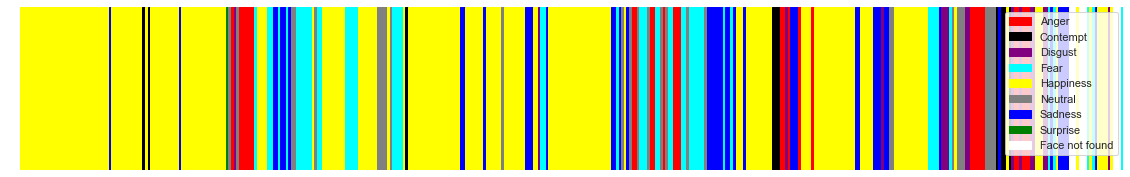

In [31]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(20, 3)})
sns.set_style('white')

fig = plt.figure()
ax = fig.add_subplot(111)
list_colors = list(color_scheme.values()) + ['white']
labels = list(color_scheme.keys()) + ['Face not found']

# invisible rectangles for labels
for color, label in zip(list_colors, labels):
    ax.add_patch(matplotlib.patches.Rectangle((0,0), 0, 0, color=color, label=label))

# visible rectangles
timestamps = frame_idxs[2]
emotions = all_emotions[2]
h = 500

for emotion, ts_prev, ts_curr in zip(emotions, [0] + timestamps[:-1], timestamps):
    duration = ts_curr - ts_prev
    if duration == FRAMES_TO_SKIP:
        ax.add_patch(matplotlib.patches.Rectangle((ts_prev,0), duration, h, color=list_colors[emotion],capstyle='round'))
    else:
        ax.add_patch(matplotlib.patches.Rectangle((ts_prev,0), duration, h, color='white'))


plt.xlim([0, timestamps[-1]])
plt.ylim([0, h])

plt.legend()
plt.axis('off')

plt.show()